In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
sns.set_style('darkgrid')

## 2 Data visualization and pre-processing

**Load the dataset in memory and plot the EcoG signals and the finger movement on the same figure
(np.load,pl.plot,pl.subplot).**

In [3]:
data = np.load('ECoG.npz')
X = data['Xall']
Y = data['Yall']
Fe = data['Fe']

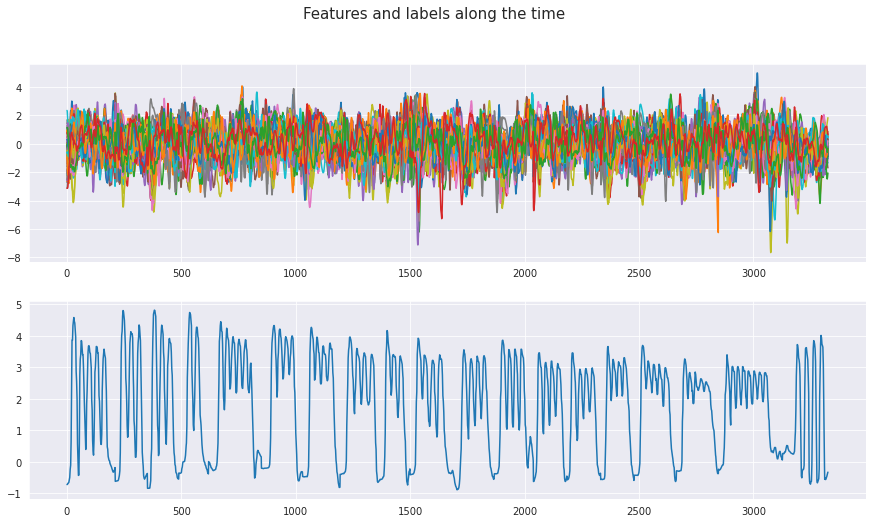

In [4]:
plt.figure(figsize=(15,8))
plt.suptitle('Features and labels along the time', fontsize=15)
plt.subplot(211)
for i in range(X.shape[1]):
    plt.plot(X[:, i])
plt.subplot(212)
plt.plot(Y)
plt.show()

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

When we look at the y signal, corresponding to the movement of the finger, we can observe a pattern, with 3-4 or 5 little peaks near the value y=4, and separated by moments where the signal is much more low (around 0, or negative values). 
Maybe the scientist that directed the experiment told the subject to move his finger every x seconds during t seconds. That would explain this kind of periodicity we can observe. 
    
Concerning the value of the electrodes, we can observe that they vary in the same range of values, mostly between -4 and 4. For some of them, we can also observe a periodicity. But it's difficult to link visually some electrodes to the signal y we want to predict. 
</div>

**Visualize the data as a scatter plot where the color of the samples is the value to predict y and their
position are variables 45 and 48 of Xall (pl.scatter with Yall controlling the color).**

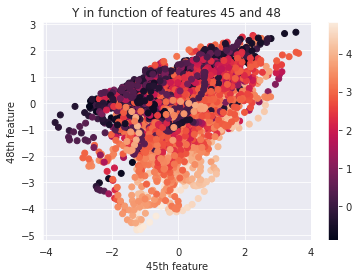

In [5]:
x = X[:,45]
y = X[:, 48]
plt.scatter(x=x, y=y, c=Y)
plt.colorbar()
plt.title('Y in function of features 45 and 48')
plt.xlabel('45th feature')
plt.ylabel('48th feature')
plt.show()

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

A priori, the 45th and the 48th features will be useful in oder to predict the movement of the finger.
They seem correlated with y. 
    
In fact, small values registred in the 48th electrodes correspond to high values of y (and vice verso). On the other hand, the correlation factor between the 45th and y seems positive. High values of thise electrode correspond to high values of y. 
</div>

In [59]:
np.corrcoef(X[:,45],Y.flatten())

array([[1.        , 0.19622142],
       [0.19622142, 1.        ]])

In [60]:
np.corrcoef(X[:,48],Y.flatten())

array([[ 1.        , -0.44281515],
       [-0.44281515,  1.        ]])

The Pearson correlation coefficient with Y is effectively positive for the 45th feature and negative for the 48th. 

**Split the data in a training and a testing set with n = 1000 training samples and the remaining samples
as testing samples (x=Xall[:n,:] to select the n first lines in a matrix).**

In [61]:
n = 1000
X_train = X[:n, :]
Y_train = Y[:n]
X_test = X[n:, ]
Y_test = Y[n:]

## 3 Least Squares regression (LS)

**Create the training matrix X˜ as defined in the course by concatenating a columns of 1s to the training
samples (np.concatenate,np.ones).**

In [62]:
X_train_til = np.concatenate((X_train, np.ones((X_train.shape[0], 1))), axis=1)
X_test_til = np.concatenate((X_test, np.ones((X_test.shape[0], 1))), axis=1)

**Estimate the LS parameters on the training data by solving the linear problem. Store those parameters
as a vector w and a bias b (np.dot,np.linalg.solve).**

In [63]:
a = np.dot(X_train_til.T, X_train_til)
b = np.dot(X_train_til.T, Y_train)
theta = np.linalg.solve(a, b)
w, b = theta[:-1].T, theta[-1]

In [64]:
w.shape

(1, 64)

In [65]:
X.shape

(3327, 64)

**Predict the finger flexion of the subject on the training and test sets. Plot the predictions along with
the true y (pl.plot). Is the prediction good on test data?**

In [66]:
Y_train_pred = np.dot(w, X_train.T) + b
Y_train_pred = Y_train_pred.flatten()
Y_test_pred = np.dot(w, X_test.T) + b
Y_test_pred = Y_test_pred.flatten()

In [67]:
def plot_labels(Y_train_pred, Y_test_pred):

    plt.figure(figsize=(15, 15))
    plt.subplot(211)
    plt.title('Preds and true train labels')
    plt.plot(Y_train, label='y_train_true')
    plt.plot(Y_train_pred, label='y_train_pred')
    plt.ylabel('Angle')
    plt.xlabel('Time')
    plt.legend()

    plt.subplot(212)
    plt.title('Preds and true test labels')
    plt.plot(Y_test, label='y_test_true')
    plt.plot(Y_test_pred, label='y_test_pred')
    plt.ylabel('Angle')
    plt.xlabel('Time')
    plt.legend()
    plt.show()

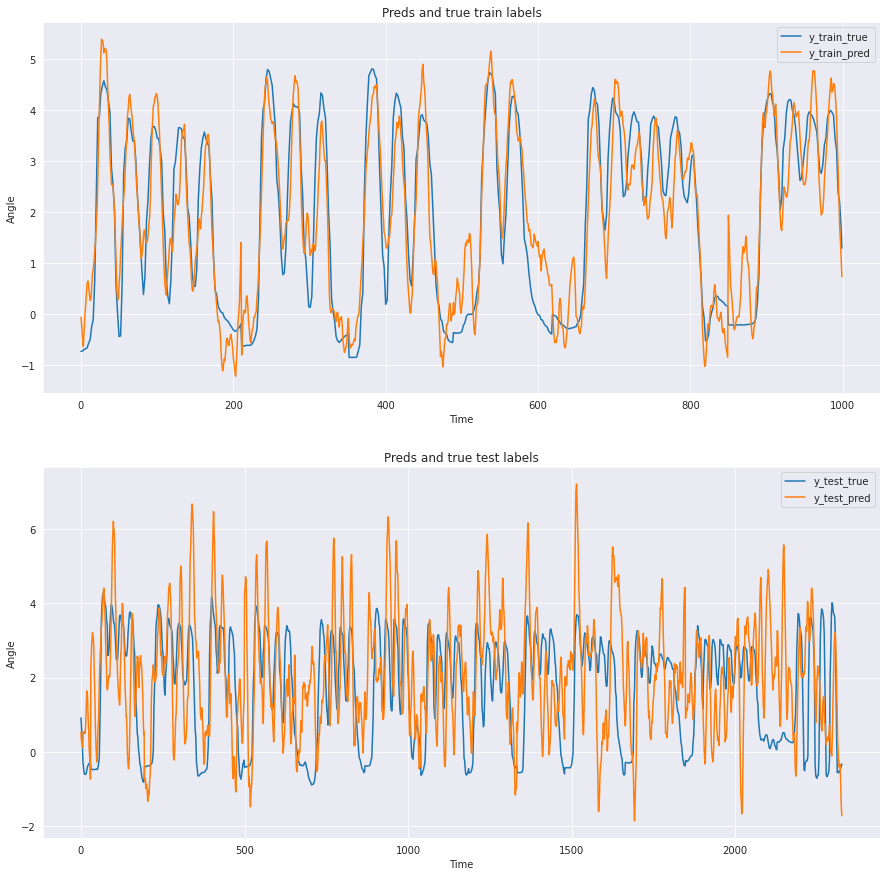

In [68]:
plot_labels(Y_train_pred, Y_test_pred)

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

The prediction is not good on the test data. It is on the training data. As said in course, the OLS overfit a lot and we need to add some regularization.
    
On the test data, the prediction has a kind of periodicity which is satisyfing but the extremum are strongly overestimated. 
    
In fact, on the Y_train signal, we have some peaks that are higher than 4, which is not the case on the Y_test signal. Because our model overfits, he will also predict high peaks for the test predictions, and so the error is important.
</div>

**Compute the performance as MSE and R2 on training and test data. Conclusions?**

In [69]:
from sklearn.metrics import mean_squared_error, r2_score

mse_train = mean_squared_error(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
r2_train = r2_score(Y_train, Y_train_pred)
r2_test = r2_score(Y_test, Y_test_pred)

In [70]:
columns = ['model', 'mse_train', 'mse_test', 'r2_train', 'r2_test']
df_score = pd.DataFrame(columns=columns)

res = {
'model' : ['OLS'], 
'mse_train': [mse_train],
'mse_test': [mse_test], 
'r2_train' : [r2_train],
'r2_test' : [r2_test]
}
tmp = pd.DataFrame(res)
df_score = pd.concat([df_score, tmp], ignore_index = True)

In [71]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.8395,-0.42817


<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

The test MSE is three time worst than the train MSE, so the model really overfit. It is also proves per the fact that the R2 test coef is negative. 
</div>

**Estimate a linear regression with sklearn.linear_model.LinearRegression and check that the estimated coefficients are the same as those estimated above (model.coef_,model.intercept_).**

In [72]:
from sklearn.linear_model import LinearRegression 

lr = LinearRegression()
lr.fit(X_train, Y_train)
ws_ols = lr.coef_.flatten()
print(np.abs(lr.coef_ - w))
print(np.abs(lr.intercept_ - b))

[[4.02455846e-16 4.01068068e-15 5.82867088e-16 5.49560397e-15
  3.44169138e-15 6.27276009e-15 3.94129174e-15 6.99440506e-15
  8.88178420e-16 7.99360578e-15 1.55431223e-15 2.14411822e-15
  2.99760217e-15 3.15719673e-15 2.94209102e-15 3.81639165e-16
  1.19348975e-15 3.33066907e-16 4.77395901e-15 5.82867088e-16
  6.55031585e-15 1.72084569e-15 2.33146835e-15 2.30371278e-15
  1.55431223e-15 3.05311332e-16 4.82947016e-15 2.99760217e-15
  4.44089210e-15 1.11022302e-16 9.96425165e-15 4.57966998e-16
  1.08246745e-15 1.31561428e-14 5.05151476e-15 1.09894732e-15
  1.80411242e-16 8.88178420e-15 6.27276009e-15 9.49240686e-15
  6.60582700e-15 5.84254867e-15 1.01030295e-14 7.00828284e-15
  2.96290770e-15 2.91433544e-15 3.15025783e-15 2.05391260e-15
  1.77635684e-15 1.85962357e-15 9.15933995e-16 8.32667268e-17
  3.02535774e-15 3.60822483e-15 1.87350135e-16 5.61876934e-15
  3.38618023e-15 9.99200722e-16 2.10942375e-15 2.88657986e-15
  3.96904731e-15 3.35842465e-15 7.91727794e-15 3.33066907e-15]]
[2.886

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

The calculated coefficients and intercepts are the same than those calculated with the sklearn functions.
</div>

## 4 Ridge regression

**Estimate the ridge predictor on the training data with λ = 1 and compute the prediction performances
on training and test set (sklearn.linear_model.Ridge).**

In [73]:
def get_preds(model):
    model.fit(X_train, Y_train.ravel())
    Y_train_pred = model.predict(X_train)
    Y_test_pred = model.predict(X_test)
    return Y_train_pred, Y_test_pred

def get_perf(Y_train_pred, Y_test_pred):
    mse_train = mean_squared_error(Y_train, Y_train_pred)
    mse_test = mean_squared_error(Y_test, Y_test_pred)
    r2_train = r2_score(Y_train, Y_train_pred)
    r2_test = r2_score(Y_test, Y_test_pred)
    print(f'MSE train : {mse_train:.3f}')
    print(f'MSE test : {mse_test:.3f}')
    print(f'R2 train : {r2_train:.3f}')
    print(f'R2 test : {r2_test:.3f}')
    return mse_train, mse_test, r2_train, r2_test

In [74]:
def add_perf(df_score, model_name, mse_train, mse_test, r2_train, r2_test):
    res = {
    'model' : [model_name], 
    'mse_train': [mse_train],
    'mse_test': [mse_test], 
    'r2_train' : [r2_train],
    'r2_test' : [r2_test]
    }
    tmp = pd.DataFrame(res)
    df_score = pd.concat([df_score, tmp], ignore_index = True)
    return df_score

In [75]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
Y_train_pred, Y_test_pred = get_preds(ridge)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, 'Ridge (lambda=1)', mse_train, mse_test, r2_train, r2_test)

MSE train : 0.504
MSE test : 3.004
R2 train : 0.839
R2 test : -0.409


In [76]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618


<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

With alpha=1, we have almost the same performances than those with a simple OLS : we need to add more regularization.
</div>

**Estimate the Ridge and, predict the labels and compute the performance for 100 values of the regularization parameter λ from 10−3
to 105
.. Plot the evolution of the MSE on training and testing data
as a function of λ. Also plot the evolution of the linear parameters as a function of λ (in the same
figure with subplot).**

In [77]:
alphas = np.logspace(start=-3, stop=5, num=100)

In [78]:
mses_train, mses_test = [], []
coefs = []

for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, Y_train)

    Y_train_pred = ridge.predict(X_train)
    Y_test_pred = ridge.predict(X_test)

    mse_train = mean_squared_error(Y_train, Y_train_pred)
    mse_test = mean_squared_error(Y_test, Y_test_pred)
    
    mses_train.append(mse_train)
    mses_test.append(mse_test)
    
    ws = ridge.coef_
    
    coefs.append(ws)
    
coefs = np.array(coefs)
coefs = coefs.reshape((100, 64))

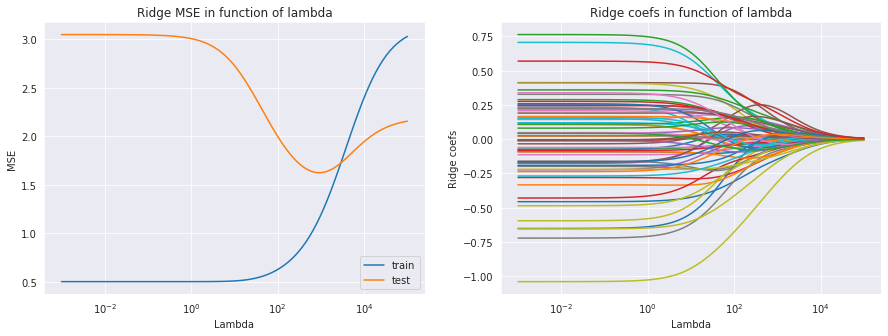

In [79]:
plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Ridge MSE in function of lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.semilogx(alphas, mses_train, label='train')
plt.semilogx(alphas, mses_test, label='test')
plt.legend()

plt.subplot(122)
plt.title('Ridge coefs in function of lambda')
plt.xlabel('Lambda')
plt.ylabel('Ridge coefs')
for i in range(coefs.shape[1]):
    plt.semilogx(alphas, coefs[:,i])
plt.show()

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

The bigger is lamda, the smaller are the coefficients of the ridge regression, because the penality is more important.
When we regularize, we lose performance on the train set but we gain on the test set until a certain lambda. 
At the beginning, the model is too complex and tends to overfit (we have a too large possibilities of regression function).
At the end, it is the opposite, we can't find a function complex enough to modelize our data. 
We need to find the lambda for which the test MSE is the lowest.

</div>

**Select the value of λ having the best performance on test data and estimate a Ridge model with this
λ (np.argmin).**

In [80]:
argmin = np.argmin(mses_test)
best_alpha = alphas[argmin]

print(f'The best value for lambda is {best_alpha:.2f}')

ridge = Ridge(alpha=best_alpha)
Y_train_pred, Y_test_pred = get_preds(ridge)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, f'Ridge (lambda={best_alpha:.2f})', mse_train, mse_test, r2_train, r2_test)

The best value for lambda is 954.55
MSE train : 1.172
MSE test : 1.624
R2 train : 0.627
R2 test : 0.238


In [81]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943,1.623906,0.626841,0.238488


<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

Lambdas around 955 give us the best performances, ie the min MSE, on the test set. It enables to have enough regularization, and to keep enough information on the data to learn their trend (no underfitting).

</div>

**Predict the finger flexion of the subject on the training and test sets. Visualize with a scatter plot the
true values VS the predictions (pl.scatter).**

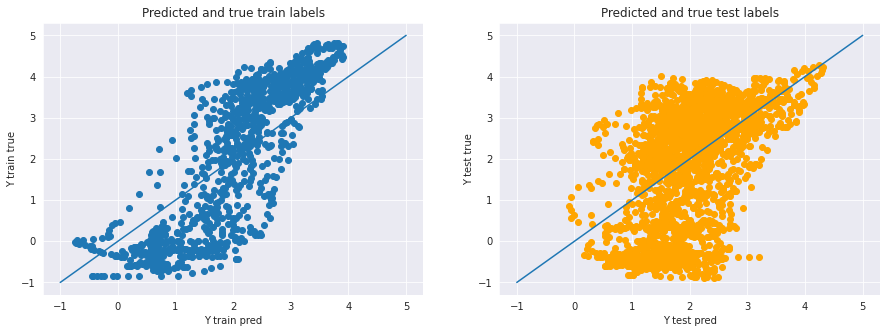

In [82]:
plt.figure(figsize=(15, 5))
Y_train_pred = ridge.predict(X_train)
Y_test_pred = ridge.predict(X_test)

plt.subplot(121)
plt.title('Predicted and true train labels')
plt.xlabel('Y train pred')
plt.ylabel('Y train true')
plt.scatter(Y_train_pred, Y_train)
plt.plot([-1,5], [-1,5])
plt.subplot(122)
plt.title('Predicted and true test labels')
plt.scatter(Y_test_pred, Y_test, color='orange')
plt.xlabel('Y test pred')
plt.ylabel('Y test true')
plt.plot([-1,5], [-1,5])
plt.show()

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

We expect the points to be close to the blue line (y=x, predicted_labels=true_labels).
For the train set, we are quiet close, which explains the low mse. 
    
For the test set, we can see bigger errors, especially for the 'middle range' points, ie points that belongs to [1,3].

</div>

**Plot the predictions along with the true y (pl.plot) as a function of time. Is the prediction good on
test data?**

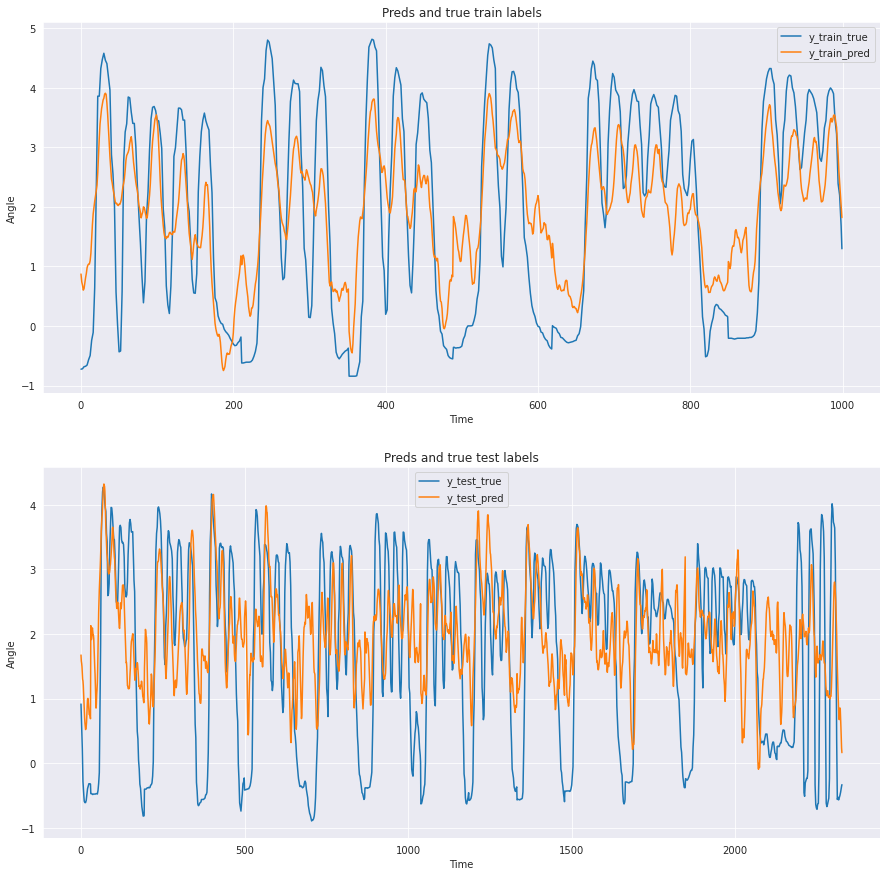

In [83]:
plot_labels(Y_train_pred, Y_test_pred)

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

The results are a little less good than those of the OLS for the train set, because we have added some regularization. 
However, it's better for the test set. With Ridge, we have a tendency to underestimate the vertexes of the curve, whereas it was the opposite for the simple OLS. Our prediction is better, but other regressors may have better results with this dataset.
    
We are much more better than OLS to predict the numerous positive peaks, but not for the several negative ones. 
</div>

**Compute the performance as MSE and R2 on training and test data. Compare with LS estimator and
discuss.**

In [84]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943,1.623906,0.626841,0.238488


<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

By adding a well chosen regularization, we have almost divided the test MSE by 2.
</div>

**Interpret the classifiers w for both LS and Ridge estimator by plotting their values and their absolute
values (pl.stem). Do they show the same important variables (large magnitude)?**

In [85]:
ws_ridge = ridge.coef_.flatten()

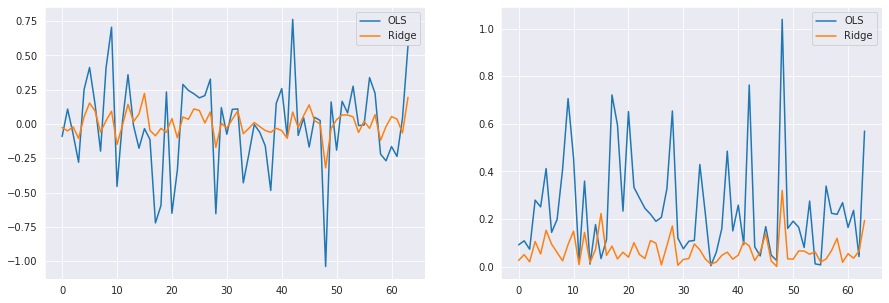

In [86]:
plt.figure(figsize=(15, 5))
plt.title('Coefs')
plt.subplot(121)
plt.plot(ws_ols, label='OLS')
plt.plot(ws_ridge, label='Ridge')
plt.legend()

plt.subplot(122)
plt.plot(np.abs(ws_ols), label='OLS')
plt.plot(np.abs(ws_ridge), label='Ridge')
plt.legend()
plt.show()

In [87]:
ws_ridge

array([-0.02640053, -0.05029049, -0.02029002, -0.10571625,  0.05316002,
        0.15274951,  0.09436534, -0.05960404,  0.02433899,  0.09325278,
       -0.14928329, -0.00844216,  0.1438586 ,  0.0162682 ,  0.07282022,
        0.22308054, -0.0472768 , -0.08615963, -0.03230092, -0.06062023,
        0.0397016 , -0.10063247,  0.0509786 ,  0.03414485,  0.10965682,
        0.09850931,  0.00731693,  0.08773057, -0.17095552,  0.00581379,
       -0.03021429,  0.03404373,  0.09524923, -0.07085093, -0.03220416,
        0.01077314, -0.019025  , -0.04747229, -0.06084588, -0.0312516 ,
       -0.04825823, -0.10435244,  0.08701048, -0.02586379,  0.06137933,
        0.13959278,  0.02391728,  0.000809  , -0.32018826, -0.03275795,
        0.03137106,  0.06599747,  0.06549858,  0.05217235, -0.06185228,
        0.01958806, -0.03206775,  0.06795038, -0.11902383, -0.01847734,
        0.05444363,  0.03564301, -0.06482949,  0.19434918])

<div class="alert alert-block alert-warning">
<b>Interpretation:</b> 

We can see on the plots that we have considerably reduced the weights of our linear model, with the regularization. It avoids to have a too complex model, that will certainly overfit. We see that the weights are now very close to zero because of the L2 regularization, but none of them is equal to zero : Ridge doesn't practice feature selection !
</div>

## 5 Variable selection with the Lasso

**Estimate the Lasso predictor on the training data with default value for the regularization parameter
(sklearn.linear_model.Lasso).**
**Predict and compute the prediction performances on training and test set, look at the estimated linear
model. Notice anything?**

In [88]:
from sklearn.linear_model import Lasso

lasso = Lasso()
Y_train_pred, Y_test_pred = get_preds(lasso)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, 'Lasso default', mse_train, mse_test, r2_train, r2_test)

MSE train : 3.141
MSE test : 2.191
R2 train : 0.000
R2 test : -0.027


In [89]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943,1.623906,0.626841,0.238488
3,Lasso default,3.140597,2.190676,0.000000,-0.027293


<div class="alert alert-block alert-warning">

We notice that with the default parameters, the model predicts better the test data than the train data. 

</div>

**Estimate the Lasso and, predict the labels and compute the performance for 100 values of the regularization parameter λ from 10−3
to 105
. (np.logspace,for i,reg in enumerate(lst_reg):). Plot
the evolution of the MSE on training and testing data as a function of λ.**

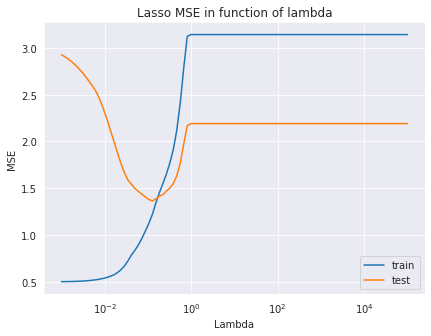

In [90]:
alphas = np.logspace(start=-3, stop=5, num=100)
mses_train, mses_test = [], []
coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha)
    lasso.fit(X_train, Y_train)

    Y_train_pred = lasso.predict(X_train)
    Y_test_pred = lasso.predict(X_test)

    mse_train = mean_squared_error(Y_train, Y_train_pred)
    mse_test = mean_squared_error(Y_test, Y_test_pred)
    
    mses_train.append(mse_train)
    mses_test.append(mse_test)
    
    ws = ridge.coef_
    
    coefs.append(ws)
    
coefs = np.array(coefs)
coefs = coefs.reshape((100, 64))

plt.figure(figsize=(15, 5))
plt.subplot(121)
plt.title('Lasso MSE in function of lambda')
plt.xlabel('Lambda')
plt.ylabel('MSE')
plt.semilogx(alphas, mses_train, label='train')
plt.semilogx(alphas, mses_test, label='test')
plt.legend()
plt.show()

<div class="alert alert-block alert-warning">

<b>Interpretation:</b> 

The profile of the curves is the same than the one of Ridge. The train MSE is low with no regularization and increases as we add some L1 penalty. The test MSE is high at the beginning, attains a minimum, and then increases. 
    
The difference with the Ridge curves is located at the right of the graph, for lambdas > 10^0.
There is a certain lambda from which the L1 penalty is too high, and all the weights are equal to zero.
For each sample x_train or x_test, we simply predict the average of the y_train, and therefore, the MSE is constant
</div>

**Select the value of λ having the best performance on test data and estimate a Lasso model with this
λ (np.argmin).**

In [91]:
argmin = np.argmin(mses_test)
best_alpha = alphas[argmin]
print(f'The best value for lambda is {best_alpha:.2f}')

The best value for lambda is 0.13


<div class="alert alert-block alert-warning">

Lambda ~ 0.1 corresponds to the minimum of the orange curve.

</div>

**Predict the finger flexion of the subject on the training and test sets. Plot the predictions along with
the true y (pl.plot) as a function of time.**

MSE train : 1.222
MSE test : 1.366
R2 train : 0.611
R2 test : 0.359


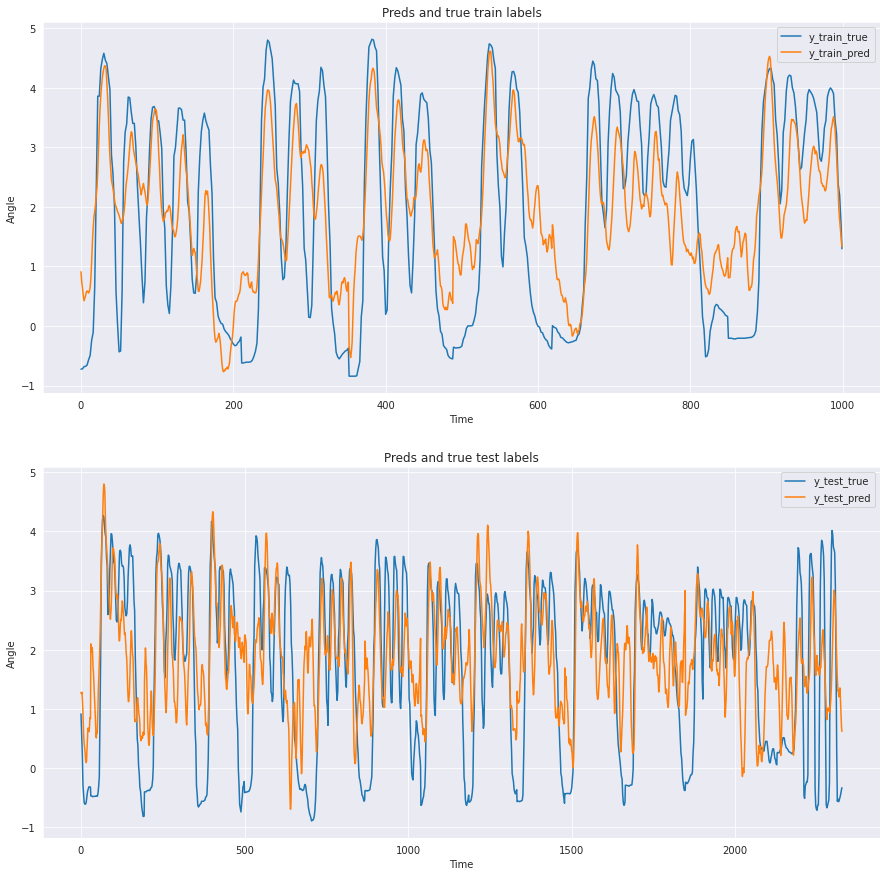

In [92]:
lasso = Lasso(alpha=best_alpha)
Y_train_pred, Y_test_pred = get_preds(lasso)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, 'Lasso (lambda=0.13)', mse_train, mse_test, r2_train, r2_test)
plot_labels(Y_train_pred, Y_test_pred)

<div class="alert alert-block alert-warning">

<b>Interpretation:</b> 

The curve profile for the test set is more satisfying than those of the previous models, especially concerning the vertexes that are closer than the blue ones. We are again goot to predict the positive peaks' order of magnitudes, more than for the neagtive ones. There are moments, for example between 300 and 500 where the prediction is far from the reality (the electrodes signals are probably far from those we have in the train set. At the opposite, between 750 and 800, the prediction is almost perfect. 

</div>

**Interpret the classifiers w for the Lasso estimator by plotting their values and their absolute values
(pl.stem). What are the two most important variables?**

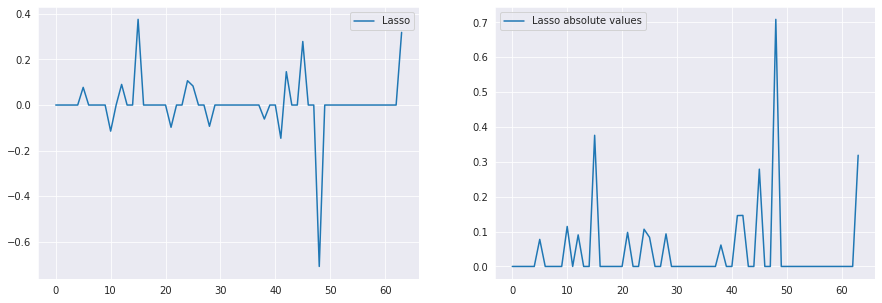

In [93]:
ws_lasso = lasso.coef_.flatten()

plt.figure(figsize=(15, 5))
plt.title('Coefs')
plt.subplot(121)
plt.plot(ws_lasso, label='Lasso')
plt.legend()

plt.subplot(122)
plt.plot(np.abs(ws_lasso), label='Lasso absolute values')
plt.legend()
plt.show()

In [94]:
print(len(ws_lasso))
len(ws_lasso[ws_lasso == 0])

64


50

In [95]:
np.argsort(-np.abs(ws_lasso))[:2]

array([48, 15])

<div class="alert alert-block alert-warning">

<b>Interpretation:</b> 

The two most important variables are the 48th and the 15th, those that we plotted at the beginning of the TP. We have seen that they separates well the high and the low values of y. 
</div>

**How many features were selected by the lasso. What would the reduction of the number of electrodes?**

In [96]:
features_selected = np.argwhere(ws_lasso != 0)
n_features_selected = len(features_selected)

In [97]:
n_features_selected

14

<div class="alert alert-block alert-warning">

<b>Interpretation:</b> 

Initially, we had 64 features. The Lasso model with a well chosen regularizatio has eliminated 50 features that it considers not to be important. It's exactly like if he had only 14 electrodes. 
    
</div>

In [98]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943,1.623906,0.626841,0.238488
3,Lasso default,3.140597,2.190676,0.000000,-0.027293
4,Lasso (lambda=0.13),1.221563,1.365954,0.611041,0.359451


<div class="alert alert-block alert-warning">

<b>Interpretation:</b> 

For now, the best regressor is the Lasso with a well chosen regularization (lambda=0.13)
    
</div>

## 6 Nonlinear regression

For the non-linear regressors, sklearn.ensemble.RandomForestRegressor, sklearn.svm.SVR, sklearn.
neural_network.MLPClassifier, sklearn.ensemble.GradientBoostingRegressor do the following:

**Fit the model with the default parameters and compute its prediction performance. Is it better than
LS (that has no parameters), Ridge or Lasso estimators?**

In [100]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

rf = RandomForestRegressor()
svr = SVR()
mlp = MLPRegressor()
gbr = GradientBoostingRegressor()

models = {
    'RandomForestRegressor':rf,
    'SVR':svr,
    'MLPRegressor':mlp,
    'GradientBoostingRegressor':gbr
         }

mses_models = {model_name : [0, 0] for model_name in models.keys()}
for model_name in models.keys() :
    print('------------------------------------')
    print(f"Model : {model_name}")
    model = models[model_name]
    Y_train_pred, Y_test_pred = get_preds(model)
    mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
    df_score = add_perf(df_score, f'{model_name} (default)', mse_train, mse_test, r2_train, r2_test)    
    print()

------------------------------------
Model : RandomForestRegressor
MSE train : 0.025
MSE test : 1.638
R2 train : 0.992
R2 test : 0.232

------------------------------------
Model : SVR
MSE train : 0.024
MSE test : 1.515
R2 train : 0.992
R2 test : 0.289

------------------------------------
Model : MLPRegressor
MSE train : 0.010
MSE test : 2.247
R2 train : 0.997
R2 test : -0.054

------------------------------------
Model : GradientBoostingRegressor
MSE train : 0.113
MSE test : 1.685
R2 train : 0.964
R2 test : 0.210



In [101]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943,1.623906,0.626841,0.238488
3,Lasso default,3.140597,2.190676,0.000000,-0.027293
4,Lasso (lambda=0.13),1.221563,1.365954,0.611041,0.359451
5,RandomForestRegressor (default),0.024621,1.637977,0.992160,0.231889
6,SVR (default),0.024086,1.515183,0.992331,0.289472
7,MLPRegressor (default),0.010280,2.246686,0.996727,-0.053558
8,GradientBoostingRegressor (default),0.113337,1.684676,0.963912,0.209990


<div class="alert alert-block alert-warning">
    
<b>Interpretation:</b> 

When we look at the MSE train, we see that it's very close to 0. These non linear models are much more complex, and so they are able to fit perfecly the train dataset. But whe we look at the MSE test, we see that complex models are not necessarily the best for this dataset. The best model is still the LASSO. 
    
Let's see if tuning the hyperparameters of these non linears models will enable to improve their scores.
</div>

**Validate (by hand, or with a loop) some of the important parameters in order to maximize the performance on test. Is the performance very dependent on the parameters?**

**Plot the predictions along with the true y (pl.plot) as a function of time. Is the regression method
good and why?**

##### A) SVR

We want to validate :
    
- C : Regularization parameter. 
- the chosen kernel


In [102]:
from sklearn.model_selection import GridSearchCV
parameters = [{'kernel': ['rbf', 'poly'], 
               'C': [1, 10, 100, 1000, 10000]}]

print("Tuning hyper-parameters")
svr = GridSearchCV(SVR(), parameters, cv = 5)
svr.fit(X_train, Y_train.ravel())

Tuning hyper-parameters


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [1, 10, 100, 1000, 10000],
                          'kernel': ['rbf', 'poly']}])

BEST PARAMETERS : C=10, gamma=scale, kernel:rbf 

MSE train : 0.006
MSE test : 1.553
R2 train : 0.998
R2 test : 0.272


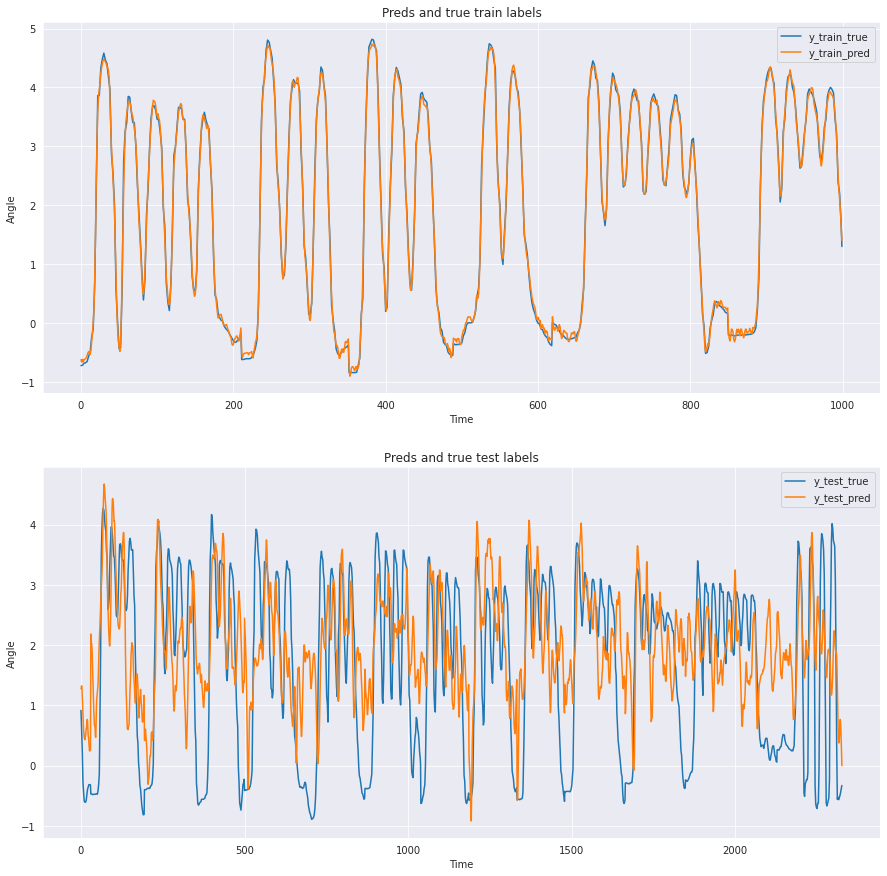

In [103]:
best_svr = svr.best_estimator_
C = best_svr.get_params()['C']
gamma = best_svr.get_params()['gamma']
kernel = best_svr.get_params()['kernel']
print(f'BEST PARAMETERS : C={C}, gamma={gamma}, kernel:{kernel} \n')

Y_train_pred, Y_test_pred = get_preds(best_svr)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, f'SVR tuned', mse_train, mse_test, r2_train, r2_test) 
plot_labels(Y_train_pred, Y_test_pred)

<div class="alert alert-block alert-warning">
    
<b>Interpretation:</b> 

The perfomance of the SVR classifier is better than the Ridge one, but worst than the LASSO. When we look at the curves, we can see that the predicted periodicity and the order of magnitudes are rather good, especially for the positive values. The regressor has difficulties at the end of the signals, but it was also the case for the other ones.
</div>

##### B) RandomForestRegressor

In [104]:
parameters = {'n_estimators': [100, 200, 400],
               'max_depth': [10, 20, None],
               'min_samples_leaf': [1, 2, 4]
              }

print("Tuning hyper-parameters")
rf= GridSearchCV(RandomForestRegressor(), parameters, cv=3, verbose=3)
rf.fit(X_train, Y_train.ravel())

Tuning hyper-parameters
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.218 total time=   1.3s
[CV 2/3] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.252 total time=   1.6s
[CV 3/3] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=0.190 total time=   1.3s
[CV 1/3] END max_depth=10, min_samples_leaf=1, n_estimators=200;, score=0.186 total time=   2.5s
[CV 2/3] END max_depth=10, min_samples_leaf=1, n_estimators=200;, score=0.245 total time=   2.6s
[CV 3/3] END max_depth=10, min_samples_leaf=1, n_estimators=200;, score=0.241 total time=   2.8s
[CV 1/3] END max_depth=10, min_samples_leaf=1, n_estimators=400;, score=0.193 total time=   5.1s
[CV 2/3] END max_depth=10, min_samples_leaf=1, n_estimators=400;, score=0.253 total time=   4.8s
[CV 3/3] END max_depth=10, min_samples_leaf=1, n_estimators=400;, score=0.223 total time=   4.8s
[CV 1/3] END max_depth=10, min_samples_lea

GridSearchCV(cv=3, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 400]},
             verbose=3)

n_estimators=100, max_depth=20, min_samples_leaf=1
MSE train : 0.024
MSE test : 1.692
R2 train : 0.992
R2 test : 0.207


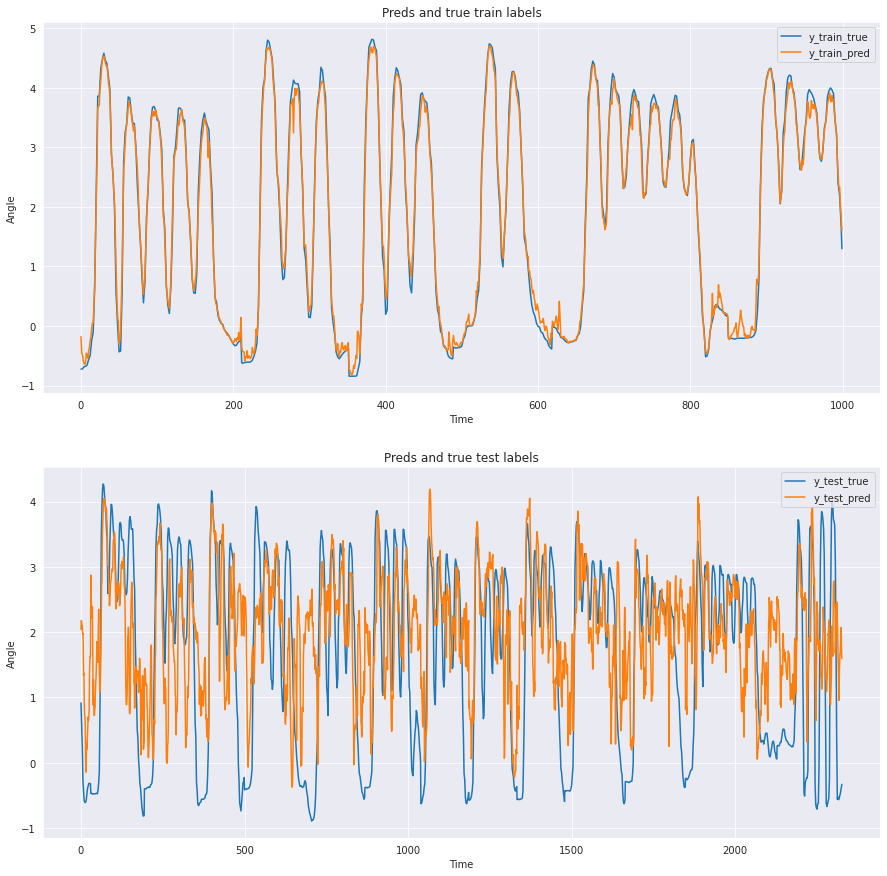

In [105]:
best_rf = rf.best_estimator_
n_estimators = best_rf.get_params()['n_estimators']
max_depth = best_rf.get_params()['max_depth']
min_samples_leaf = best_rf.get_params()['min_samples_leaf']
print(f'n_estimators={n_estimators}, max_depth={max_depth}, min_samples_leaf={min_samples_leaf}')

Y_train_pred, Y_test_pred = get_preds(best_rf)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, f'RandomForestRegressor tuned', mse_train, mse_test, r2_train, r2_test) 
plot_labels(Y_train_pred, Y_test_pred)

In [106]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943,1.623906,0.626841,0.238488
3,Lasso default,3.140597,2.190676,0.000000,-0.027293
4,Lasso (lambda=0.13),1.221563,1.365954,0.611041,0.359451
5,RandomForestRegressor (default),0.024621,1.637977,0.992160,0.231889
6,SVR (default),0.024086,1.515183,0.992331,0.289472
7,MLPRegressor (default),0.010280,2.246686,0.996727,-0.053558
8,GradientBoostingRegressor (default),0.113337,1.684676,0.963912,0.209990
9,SVR tuned,0.006274,1.553232,0.998002,0.271629


<div class="alert alert-block alert-warning">
    
<b>Interpretation:</b> 

We can notice that, even we a cross validation with 3-fold, the MSE test for the non linear models are better with the default parameters than with the tuned ones. 
</div>

##### C) MLP

In [107]:
parameters = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.1],
               'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
              }

print("Tuning hyper-parameters")
mlp = GridSearchCV(MLPRegressor(), parameters, cv=3, verbose=3)
mlp.fit(X_train, Y_train.ravel())

Tuning hyper-parameters
Fitting 3 folds for each of 15 candidates, totalling 45 fits
[CV 1/3] END alpha=1e-05, hidden_layer_sizes=(50, 50, 50);, score=0.203 total time=   1.0s
[CV 2/3] END alpha=1e-05, hidden_layer_sizes=(50, 50, 50);, score=0.142 total time=   1.0s
[CV 3/3] END alpha=1e-05, hidden_layer_sizes=(50, 50, 50);, score=-0.258 total time=   1.0s
[CV 1/3] END alpha=1e-05, hidden_layer_sizes=(50, 100, 50);, score=0.334 total time=   0.9s
[CV 2/3] END alpha=1e-05, hidden_layer_sizes=(50, 100, 50);, score=-0.043 total time=   1.1s
[CV 3/3] END alpha=1e-05, hidden_layer_sizes=(50, 100, 50);, score=-0.252 total time=   1.1s
[CV 1/3] END alpha=1e-05, hidden_layer_sizes=(100,);, score=0.251 total time=   0.8s
[CV 2/3] END alpha=1e-05, hidden_layer_sizes=(100,);, score=0.011 total time=   0.6s
[CV 3/3] END alpha=1e-05, hidden_layer_sizes=(100,);, score=0.078 total time=   0.9s
[CV 1/3] END alpha=0.0001, hidden_layer_sizes=(50, 50, 50);, score=0.290 total time=   0.9s
[CV 2/3] END alp

/mnt/c/Users/Paul/Desktop/2122/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END alpha=0.1, hidden_layer_sizes=(50, 50, 50);, score=0.289 total time=   1.9s
[CV 3/3] END alpha=0.1, hidden_layer_sizes=(50, 50, 50);, score=-0.068 total time=   1.3s


/mnt/c/Users/Paul/Desktop/2122/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 1/3] END alpha=0.1, hidden_layer_sizes=(50, 100, 50);, score=0.140 total time=   3.5s


/mnt/c/Users/Paul/Desktop/2122/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 2/3] END alpha=0.1, hidden_layer_sizes=(50, 100, 50);, score=-0.039 total time=   3.0s


/mnt/c/Users/Paul/Desktop/2122/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END alpha=0.1, hidden_layer_sizes=(50, 100, 50);, score=-0.093 total time=   3.0s
[CV 1/3] END alpha=0.1, hidden_layer_sizes=(100,);, score=0.253 total time=   1.1s
[CV 2/3] END alpha=0.1, hidden_layer_sizes=(100,);, score=-0.077 total time=   1.3s


/mnt/c/Users/Paul/Desktop/2122/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV 3/3] END alpha=0.1, hidden_layer_sizes=(100,);, score=0.174 total time=   1.4s


GridSearchCV(cv=3, estimator=MLPRegressor(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)]},
             verbose=3)

alpha=0.1, hidden_layer_sizes=(50, 50, 50)
MSE train : 0.002
MSE test : 2.492
R2 train : 0.999
R2 test : -0.169


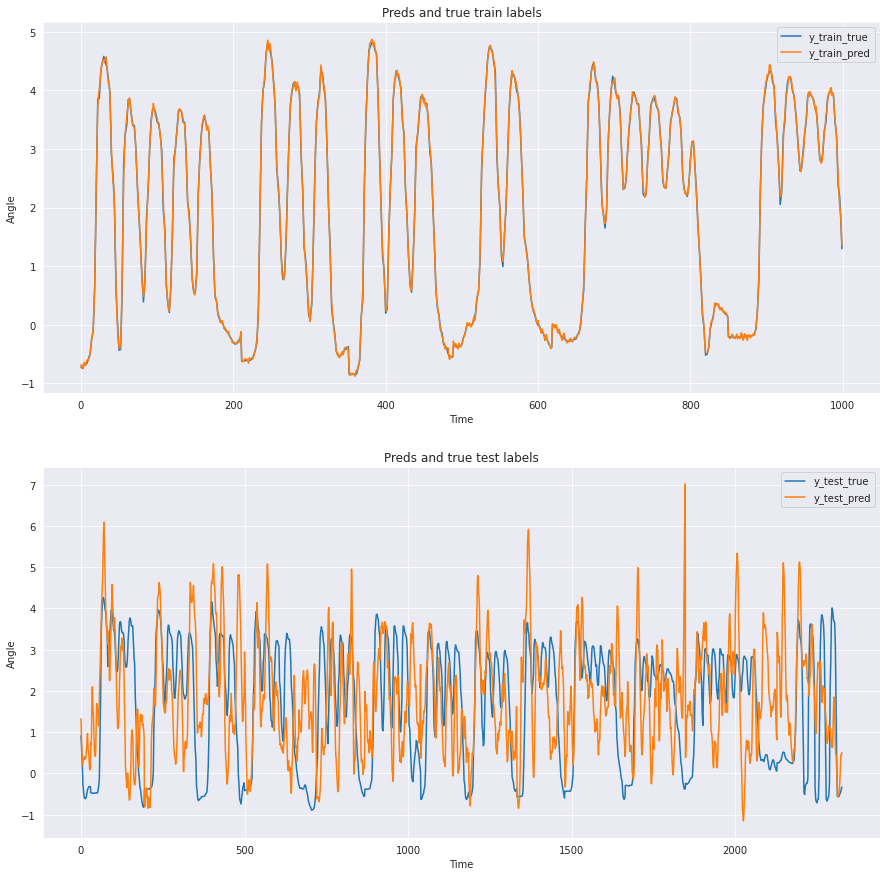

In [108]:
best_mlp = mlp.best_estimator_
alpha = best_mlp.get_params()['alpha']
hidden_layer_sizes = best_mlp.get_params()['hidden_layer_sizes']
print(f'alpha={alpha}, hidden_layer_sizes={hidden_layer_sizes}')

Y_train_pred, Y_test_pred = get_preds(best_mlp)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, f'MLPRegressor tuned', mse_train, mse_test, r2_train, r2_test) 
plot_labels(Y_train_pred, Y_test_pred)

In [109]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,0.504065,3.045537,0.839500,-0.428170
1,Ridge (lambda=1),0.504177,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943,1.623906,0.626841,0.238488
3,Lasso default,3.140597,2.190676,0.000000,-0.027293
4,Lasso (lambda=0.13),1.221563,1.365954,0.611041,0.359451
5,RandomForestRegressor (default),0.024621,1.637977,0.992160,0.231889
6,SVR (default),0.024086,1.515183,0.992331,0.289472
7,MLPRegressor (default),0.010280,2.246686,0.996727,-0.053558
8,GradientBoostingRegressor (default),0.113337,1.684676,0.963912,0.209990
9,SVR tuned,0.006274,1.553232,0.998002,0.271629


<div class="alert alert-block alert-warning">
    
<b>Interpretation:</b> 

With the validated parameters, the MSE test is not satisfying. It must be because of the huge peak around 7 predicted at the end of the signal. The MLP regressor is too complex for our task and provoke a high variance.
</div>

##### D) GradientBoostingRegressor

In [110]:
parameters = {'n_estimators': [100, 200, 400],
               'max_depth': [10, 20, None],
               'min_samples_leaf': [1, 2, 4]
              }

print("Tuning hyper-parameters")
gbr = GridSearchCV(GradientBoostingRegressor(), parameters, cv=3, verbose=3)
gbr.fit(X_train, Y_train.ravel())

Tuning hyper-parameters
Fitting 3 folds for each of 27 candidates, totalling 81 fits
[CV 1/3] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=-0.271 total time=   2.2s
[CV 2/3] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=-0.244 total time=   2.4s
[CV 3/3] END max_depth=10, min_samples_leaf=1, n_estimators=100;, score=-0.186 total time=   2.2s
[CV 1/3] END max_depth=10, min_samples_leaf=1, n_estimators=200;, score=-0.315 total time=   5.1s
[CV 2/3] END max_depth=10, min_samples_leaf=1, n_estimators=200;, score=-0.257 total time=   5.4s
[CV 3/3] END max_depth=10, min_samples_leaf=1, n_estimators=200;, score=-0.182 total time=   4.8s
[CV 1/3] END max_depth=10, min_samples_leaf=1, n_estimators=400;, score=-0.261 total time=  11.0s
[CV 2/3] END max_depth=10, min_samples_leaf=1, n_estimators=400;, score=-0.227 total time=  11.1s
[CV 3/3] END max_depth=10, min_samples_leaf=1, n_estimators=400;, score=-0.186 total time=  11.8s
[CV 1/3] END max_depth=10, min_sa

GridSearchCV(cv=3, estimator=GradientBoostingRegressor(),
             param_grid={'max_depth': [10, 20, None],
                         'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 400]},
             verbose=3)

n_estimators=400, max_depth=None, min_samples_leaf=4
MSE train : 0.000
MSE test : 2.219
R2 train : 1.000
R2 test : -0.041


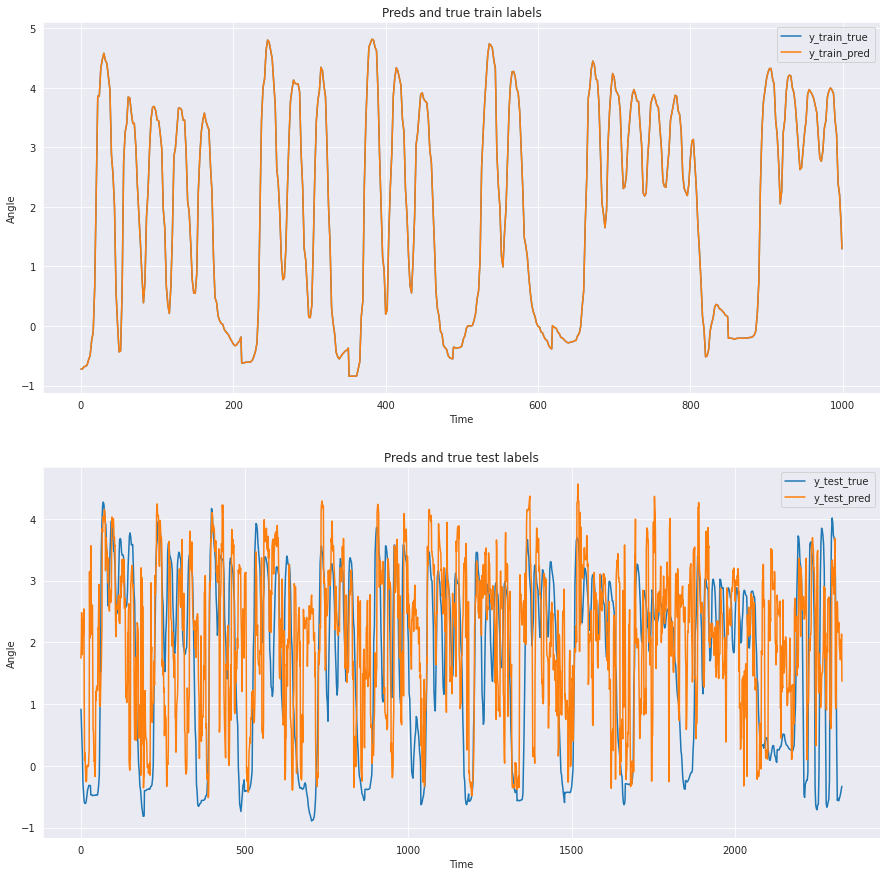

In [111]:
best_gbr = gbr.best_estimator_
n_estimators = best_gbr.get_params()['n_estimators']
max_depth = best_gbr.get_params()['max_depth']
min_samples_leaf = best_gbr.get_params()['min_samples_leaf']
print(f'n_estimators={n_estimators}, max_depth={max_depth}, min_samples_leaf={min_samples_leaf}')

Y_train_pred, Y_test_pred = get_preds(best_gbr)
mse_train, mse_test, r2_train, r2_test = get_perf(Y_train_pred, Y_test_pred)
df_score = add_perf(df_score, f'GradientBoostingRegressor tuned', mse_train, mse_test, r2_train, r2_test) 
plot_labels(Y_train_pred, Y_test_pred)

In [122]:
df_score

,model,mse_train,mse_test,r2_train,r2_test
0,OLS,6.273618e-03,1.553232,0.998002,0.271629
1,Ridge (lambda=1),5.041768e-01,3.003843,0.839465,-0.408618
2,Ridge (lambda=954.55),1.171943e+00,1.623906,0.626841,0.238488
3,Lasso default,3.140597e+00,2.190676,0.000000,-0.027293
4,Lasso (lambda=0.13),1.221563e+00,1.365954,0.611041,0.359451
5,Lasso (lambda=0.13),1.221563e+00,1.365954,0.611041,0.359451
6,RandomForestRegressor (default),2.356551e-02,1.703237,0.992496,0.201286
7,SVR (default),2.408598e-02,1.515183,0.992331,0.289472
8,MLPRegressor (default),7.314403e-03,2.038738,0.997671,0.043957
9,GradientBoostingRegressor (default),1.133371e-01,1.673451,0.963912,0.215254


<div class="alert alert-block alert-warning">
    
<b>Interpretation:</b> 
    
With the 3-Fold Cross-Validation, we can predict perfectly the train set. But the model overfits, because it as a high error on the test set. 
The predicted Y test is very noisy : we don't recover the periodicity of the test signals as other models do.

</div>

## 7 Final comparison of the performances

**Collect the test performances for all methods investigated above in a table (in a dataframe and printing
it for instance). Which methods work the best in practice?**

In [112]:
df_score_sorted = df_score.sort_values(by='mse_test').reset_index()

In [113]:
df_score_sorted['model'][:5]

0                Lasso (lambda=0.13)
1                      SVR (default)
2                          SVR tuned
3              Ridge (lambda=954.55)
4    RandomForestRegressor (default)
Name: model, dtype: object

<div class="alert alert-block alert-warning">
    
<b>Interpretation:</b> 

The best model is definitively the LASSO model with the well chosen L1 regularization

</div>

**What are the most interpretable models?**

<div class="alert alert-block alert-warning">

The most interpretable models are the linear ones (OLS, Ridge and Lasso). With the coefficients, we can understand easily the contribution of each one of the features to the predicted signal. 
    
The others appears more like a 'black box'. It's difficult to understand how the model pass from the features to the predictions. A Decision Tree is also interpretable, but with ensemble methods like RandomForest, we lose the interpretability of the different trees when we mix them.
</div>

**Which model is best from a medical/practical perspective?**

<div class="alert alert-block alert-warning">

The best model from a medical perspective is clearly LASSO.
On the one hand, it is interpretable for the doctor, who will understand the contribution of each region of the brain to the finger's movement. 
On the other hand, it practices feature selection. A doctor can understand which region are the more important (we have seen that the region corresponding to the 45th and the 48th electrode are very meaningful for this experiment). 
And he can even see which feature we can neglect. Here we have seen that among the 64 features proposed, only 14 are meaningful : the best model obtained uses only these 14 regions of the brain to predict the fingers' movement ! 
</div>

**Do we need non-linearity in this application?**

<div class="alert alert-block alert-warning">

For this application we have seen that linear application are more appropriate : we don't need to complexify our model with non linearities !
</div>

**Is validation on the test data a good practice? What would you do if you need to provide a model to
a client for prediction in production?**

<div class="alert alert-block alert-warning">

The good practice is to divide our dataset in 3:
    
- Train set : will enable to chose the appropriate regressor
- Validation set : will enable to validate the parameters of this regressor
- Test set: to check that we are not overfitting
    
We can also forget the validation set and practice Cross-Validation with different folds created with the train set
</div>

<div class="alert alert-block alert-success">
<b>Conclusion:</b>

1) What was hard to understand ?
    
To my mind, the two main difficulties are to choose the parameters to tune for the non-linear models (the parameters and their values range), and to implement for the first time the grid search. 
    
    
2) What was new ? + personal discussion about how to use these tools in a professional setting
    
I really discovered the power of simple models like linear ones. 
It is interesting to see that for this task, they perform better than MLP for example. 
When you think about a prediction task, you may think "let's do it with a neural networks. they must learn perfeclty my dataset", just because deep learning and trendy. 
What I will remember of this practical section for my future professonal life, is to begin with simple models like linearn ones, because they can perform very well on certain simple dataset like this one.    

    
</div>